<a href="https://colab.research.google.com/github/loiswoo/Time-Series/blob/main/TS_study_w3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S&P 500 Stocks Prediction using ARIMA


https://www.kaggle.com/code/yassinesfaihi/arima-time-series-forecasting-s-p-500-stock/notebook

참고한 자료들: 3주차  baseline, 
삼성 주가 예측 코드


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import r2_score

In [35]:
!pip install sklearn.metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sklearn.metrics (from versions: none)
ERROR: No matching distribution found for sklearn.metrics


In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [32]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.8 MB/s eta 0:00:00


In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

In [4]:
df = pd.read_csv("/content/all_stocks_5yr.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169676 entries, 0 to 169675
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    169676 non-null  object 
 1   Open    169569 non-null  float64
 2   High    169619 non-null  float64
 3   Low     169613 non-null  float64
 4   Close   169675 non-null  float64
 5   Volume  169269 non-null  float64
 6   Name    169675 non-null  object 
dtypes: float64(5), object(2)
memory usage: 9.1+ MB


In [5]:
df = df.dropna()

In [6]:
df['Date'] = pd.to_datetime(df.Date)

df = df.set_index(df.Date)
df.drop('Date', axis = 1, inplace = True)

In [ ]:
df.shape

(606011, 6)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2012-08-13,92.29,92.59,91.74,92.40,2075391.00,MMM
2012-08-14,92.36,92.50,92.01,92.30,1843476.00,MMM
2012-08-15,92.00,92.74,91.94,92.54,1983395.00,MMM
2012-08-16,92.75,93.87,92.21,93.74,3395145.00,MMM
2012-08-17,93.93,94.30,93.59,94.24,3069513.00,MMM


## 1. Check for Stationarity of Time Series

In [57]:
ts = df['Close']
ts.head()

Date
2012-08-13   92.40
2012-08-14   92.30
2012-08-15   92.54
2012-08-16   93.74
2012-08-17   94.24
Name: Close, dtype: float64

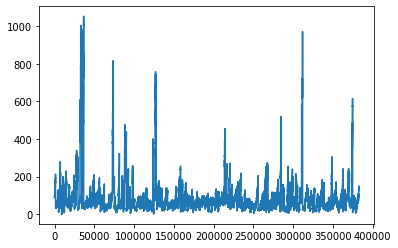

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(range(len(ts)), ts)

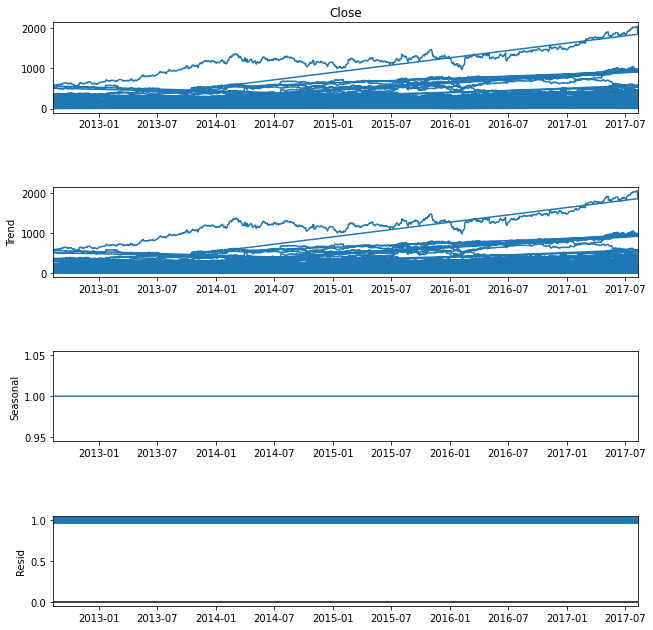

In [7]:
decomposition = sm.tsa.seasonal_decompose(df['Close'], model = 'multiplicative', period = 1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [8]:
#train:test = 8:2
#test: 121202
df_train = df[:484808]
df_test = df[484808:]

In [ ]:
df_train['Close'].describe()

count   484808.00
mean        81.28
std        101.63
min          1.59
25%         37.24
50%         58.27
75%         89.38
max       2049.00
Name: Close, dtype: float64

In [ ]:
df_test

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2015-07-28,83.81,85.16,83.37,84.73,1213778.00,COL
2015-07-29,85.03,85.59,84.64,84.84,1200762.00,COL
2015-07-30,84.54,85.52,84.30,85.05,938299.00,COL
2015-07-31,85.45,85.45,84.32,84.62,749968.00,COL
2015-08-03,85.01,85.54,84.51,85.20,900623.00,COL
...,...,...,...,...,...,...
2017-08-07,62.12,62.34,61.25,61.83,4208287.00,ZTS
2017-08-08,60.49,61.00,59.50,60.00,4663668.00,ZTS
2017-08-09,59.95,60.87,59.76,60.81,4017297.00,ZTS


<Axes: ylabel='Density'>

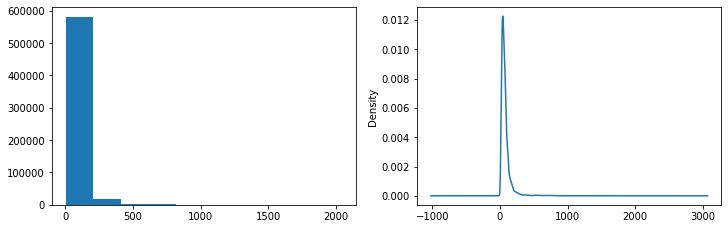

In [60]:
plt.figure(figsize =(12,8))
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')

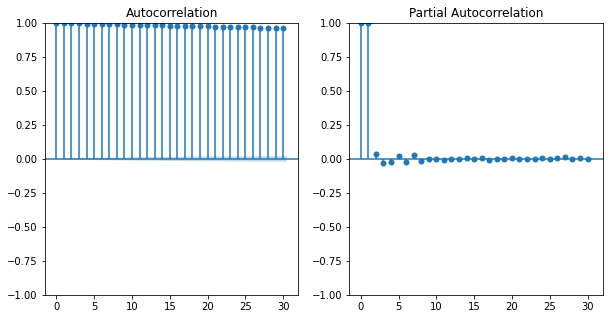

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(df_train.Close.values.squeeze(), lags = 30, ax=ax[0] );
sm.graphics.tsa.plot_pacf(df_train.Close.values.squeeze(), lags = 30, ax = ax[1]);

Autocorrelation에서 서서히 감소하고 있기 때문에 Non-stationary한 데이터라고 볼 수 있다. 따라서 Differencing(차분) 과정을 거칠 필요가 있다.

## 2. Make the Series Staionary

In [9]:
#Differencing

diff_df_train = df_train.copy()
diff_df_train = diff_df_train['Close'].diff()
diff_df_train = diff_df_train.dropna()
print('###### Raw Data #####')
print(df_train['Close'])
print('###### Differneced Data ####')
print(diff_df_train)

###### Raw Data #####
Date
2012-08-13   92.40
2012-08-14   92.30
2012-08-15   92.54
2012-08-16   93.74
2012-08-17   94.24
              ... 
2015-07-21   88.91
2015-07-22   87.72
2015-07-23   88.41
2015-07-24   85.46
2015-07-27   83.44
Name: Close, Length: 484808, dtype: float64
###### Differneced Data ####
Date
2012-08-14   -0.10
2012-08-15    0.24
2012-08-16    1.20
2012-08-17    0.50
2012-08-20   -0.35
              ... 
2015-07-21   -3.28
2015-07-22   -1.19
2015-07-23    0.69
2015-07-24   -2.95
2015-07-27   -2.02
Name: Close, Length: 484807, dtype: float64


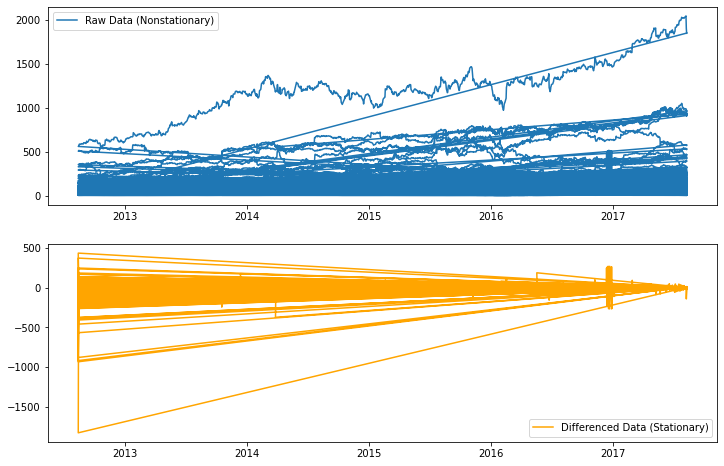

In [10]:
plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(df_train['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_df_train, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

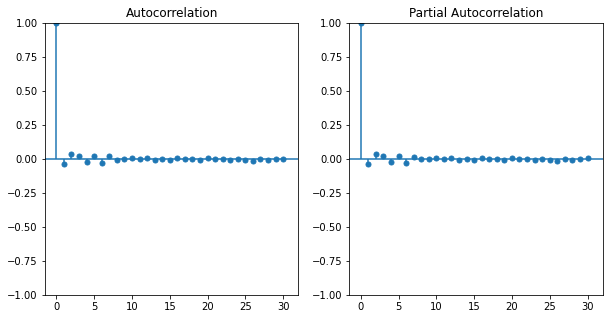

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
sm.graphics.tsa.plot_acf(diff_df_train.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_df_train.values.squeeze(), lags = 30, ax = ax[1]); #그래프 한번만 출력하기 위해서 ; 추가

1차 차분을 통해 확인한 결과, Autocorrelation이 lag2일때 급격하게 낮아지고 있고, 특정한 패턴을 보이지 않기 때문에 Stationary한 데이터라고 볼 수 있다

## 3. Forecasting a Time Series to Test Set

In [13]:
model = ARIMA(df_train['Close'], order = (1,1,0))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:               484808
Model:                 ARIMA(1, 1, 0)   Log Likelihood            -1477195.622
Date:                Wed, 22 Mar 2023   AIC                        2954395.244
Time:                        17:34:45   BIC                        2954417.427
Sample:                             0   HQIC                       2954401.532
                             - 484808                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0374      0.000   -325.103      0.000      -0.038      -0.037
sigma2        25.9476      0.000   7.08e+04      0.000      25.947      25.948
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):    35348795011191.88
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                          -141.28
Prob(H) (two-sided):                  0.00   Kurtosis:                     41834.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
import itertools
p = range(0,2)
d = range(1,2)
q = range(0,2)
pdq = list(itertools.product(p,d,q))
aic = []
for i in pdq:
  try:
    model = ARIMA(df_train['Close'], order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
  except:
    pass

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (0, 1, 0) >> AIC: 2955071.38


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (0, 1, 1) >> AIC: 2954438.57


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (1, 1, 0) >> AIC: 2954395.24


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (1, 1, 1) >> AIC: 2954199.85


In [19]:
import itertools
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
aic = []
for i in pdq:
  try:
    model = ARIMA(df_train['Close'], order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
  except:
    pass

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (0, 1, 0) >> AIC: 2955071.38


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (0, 1, 1) >> AIC: 2954438.57


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (0, 1, 2) >> AIC: 2953807.87


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (1, 1, 0) >> AIC: 2954395.24


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (1, 1, 1) >> AIC: 2954199.85


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (1, 1, 2) >> AIC: 2953742.52


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (2, 1, 0) >> AIC: 2953876.15


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (2, 1, 1) >> AIC: 2953774.61


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

ARIMA: (2, 1, 2) >> AIC: 2953688.21


In [20]:
optimal = [(pdq[i], j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 2953688.21)]

In [21]:
model_opt = ARIMA(df_train['Close'], order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:               484808
Model:                 ARIMA(2, 1, 2)   Log Likelihood            -1476839.104
Date:                Wed, 22 Mar 2023   AIC                        2953688.209
Time:                        17:48:52   BIC                        2953743.666
Sample:                             0   HQIC                       2953703.928
                             - 484808                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1242      0.006     19.224      0.000       0.112       0.137
ar.L2         -0.1711      0.004    -39.152      0.000      -0.180      -0.162
ma.L1         -0.1612      0.006    -24.876      0.000      -0.174      -0.148
ma.L2          0.2125      0.004     50.889      0.000       0.204       0.221
sigma2        25.9092      0.001   3.62e+04      0.000      25.908      25.911
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):    35006441281134.22
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                          -140.84
Prob(H) (two-sided):                  0.00   Kurtosis:                     41630.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
forecast = model_opt_fit.forecast(121203)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [25]:
list(forecast)

[83.43793449735949,
 83.32484130534307,
 83.31114870654726,
 83.3287935293399,
 83.33332719487458,
 83.33087199066394,
 83.32979154342469,
 83.33007733485326,
 83.33029764785428,
 83.33027612352835,
 83.33023576411568,
 83.33023443346053,
 83.33024117196707,
 83.33024223649254,
 83.33024121603367,
 83.33024090720018,
 83.33024104340066,
 83.33024111314467,
 83.33024109850864,
 83.33024108476066,
 83.33024108555679,
 83.33024108800737,
 83.33024108817554,
 83.33024108777724,
 83.33024108769901,
 83.33024108775743,
 83.33024108777806,
 83.33024108777063,
 83.33024108776618,
 83.33024108776691,
 83.33024108776776,
 83.33024108776775,
 83.3302410877676,
 83.33024108776759,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 83.33024108776762,
 8

In [39]:
fcast = list(forecast)

In [40]:
print(f"MSE : {mean_squared_error(df_test['Close'], fcast)}")
print(f"RMSE : {np.sqrt(mean_squared_error(df_test['Close'],fcast))}")
print(f"MAE : {mean_absolute_error(df_test['Close'],fcast)}")
print(f"MAPE : {mean_absolute_percentage_error(df_test['Close'],fcast)}")
print(f"R2 : {r2_score(df_test['Close'], fcast)}")

MSE : 1935.0152633500265
RMSE : 43.9888083874754
MAE : 34.396495751019025
MAPE : 0.7642286330481917
R2 : -0.07882631923162786


In [27]:
fore = model_opt_fit.forecast(10)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
fore

484808   83.44
484809   83.32
484810   83.31
484811   83.33
484812   83.33
484813   83.33
484814   83.33
484815   83.33
484816   83.33
484817   83.33
Name: predicted_mean, dtype: float64

In [31]:
ffcast = list(fore)

In [38]:
print(f"MSE : {mean_squared_error(df_test['Close'][:10], ffcast)}")
print(f"RMSE : {np.sqrt(mean_squared_error(df_test['Close'][:10],ffcast))}")
print(f"MAE : {mean_absolute_error(df_test['Close'][:10],ffcast)}")
print(f"MAPE : {mean_absolute_percentage_error(df_test['Close'][:10],ffcast)}")
print(f"R2 : {r2_score(df_test['Close'][:10], ffcast)}")

MSE : 4.646070098691897
RMSE : 2.155474448628862
MAE : 1.94626401262112
MAPE : 0.0227089807721209
R2 : -4.488143377876337


## 4. Forecasting a Time Series to Future

Text(0.5, 1.0, 'Train and Test Data')

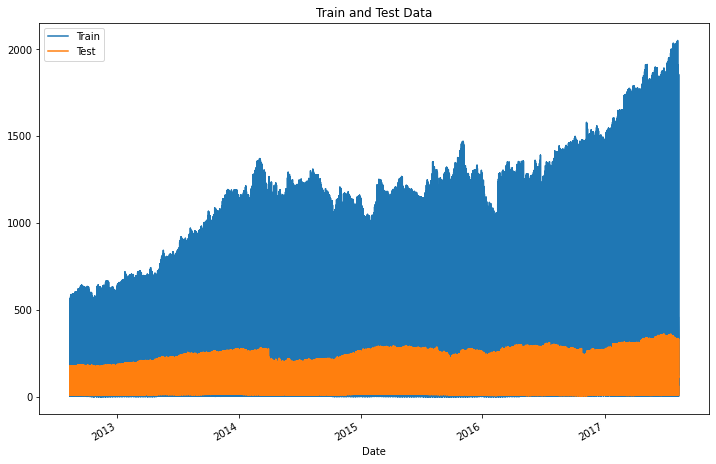

In [41]:
df_train['Close'].plot(legend = True, label ='Train')
df_test['Close'].plot(legend = True, label = 'Test', figsize = (12, 8))plt.title('Train and Test Data')

In [ ]:
forecast = model_opt_fit.forecast(121203)

In [42]:
#Final model 
fin_model= ARIMA(df['Close'], order = optimal[0][0]).fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels

In [47]:
forecast_predictions = fin_model.forecast(50)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [59]:
forecast_predictions

606011   59.72
606012   59.70
606013   59.71
606014   59.71
606015   59.71
606016   59.71
606017   59.71
606018   59.71
606019   59.71
606020   59.71
606021   59.71
606022   59.71
606023   59.71
606024   59.71
606025   59.71
606026   59.71
606027   59.71
606028   59.71
606029   59.71
606030   59.71
606031   59.71
606032   59.71
606033   59.71
606034   59.71
606035   59.71
606036   59.71
606037   59.71
606038   59.71
606039   59.71
606040   59.71
606041   59.71
606042   59.71
606043   59.71
606044   59.71
606045   59.71
606046   59.71
606047   59.71
606048   59.71
606049   59.71
606050   59.71
606051   59.71
606052   59.71
606053   59.71
606054   59.71
606055   59.71
606056   59.71
606057   59.71
606058   59.71
606059   59.71
606060   59.71
Name: predicted_mean, dtype: float64

In [48]:
forecast_pred = list(forecast_predictions)

In [52]:
forecast_pred

[59.71532745195316,
 59.703874117419325,
 59.70502032930079,
 59.70712531549682,
 59.70718098821855,
 59.70682607313476,
 59.706773924751644,
 59.70682863506531,
 59.70684415760947,
 59.70683662194942,
 59.70683305130785,
 59.70683391735768,
 59.70683463463738,
 59.70683457193079,
 59.706834441192385,
 59.70683443627733,
 59.70683445814587,
 59.7068344616141,
 59.706834458273654,
 59.706834457277076,
 59.70683445773132,
 59.706834457957015,
 59.70683445790606,
 59.70683445786118,
 59.706834457864545,
 59.70683445787266,
 59.70683445787306,
 59.706834457871715,
 59.70683445787149,
 59.70683445787169,
 59.70683445787176,
 59.70683445787173,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.706834457871715,
 59.7068344578717

Text(0.5, 1.0, 'Stock Price Forecast')

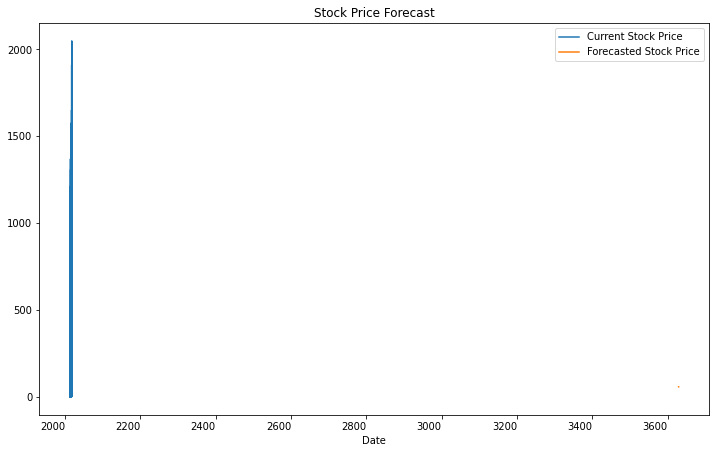

In [58]:
ts.plot(figsize = (12, 8), legend = True, label = 'Current Stock Price')
forecast_predictions.plot(legend = True, label = 'Forecasted Stock Price')
plt.title('Stock Price Forecast')

In [ ]:
#auto_arima ram 부족 
auto_arima_model = auto_arima(df_train['Close'], start_p = 1, start_q =1,
                              max_p =3, max_q =3, seasonal = False,
                              d =1,
                              trace = True, #stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2955073.377, Time=7.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2954440.568, Time=22.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2953809.873, Time=27.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2953684.963, Time=41.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2954397.244, Time=9.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2954201.852, Time=70.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2953744.520, Time=182.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2953072.332, Time=300.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2953878.149, Time=14.46 sec


In [ ]:
auto_arima_model.summary()

In [ ]:
prediction = auto_arima_model.predict(len(df_test['Close']), return_conf_int = True) #return_conf_int:
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(df_test.index)
predict_index[0]

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
df.Close.plot(ax = ax);
ax.vline
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results')
plt.show()